In [1]:
import sys
import numpy as np
sys.path.append('/Users/IzmailovPavel/Documents/Education/Projects/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from scipy.linalg import orth

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data_params = np.array([1.0, 0.2, 0.05])
data_covariance_obj = SquaredExponential(data_params)

In [3]:
gp = GPR(data_covariance_obj)
num = 1000
test_num = 100
dim = 2
seed = 10

In [4]:
np.random.seed(seed)
x_tr = np.random.normal(size=(dim, num))
if dim == 1:
    x_test = np.linspace(0, 1, test_num)
    x_test = x_test.reshape(1, test_num)
else:
    x_test = np.random.normal(size=(dim, test_num))

x_tr /= 3
x_test /= 3
# y_tr, y_test = gp.generate_data(x_tr, x_test, seed=seed)
x_tr = x_tr.T
x_test = x_test.T

x_grid, y_grid = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
x_vizualization = np.hstack([x_grid.reshape(-1)[:, None], y_grid.reshape(-1)[:, None]])

In [5]:
def inverse_sigmoid(x):
    return np.log(x / (1-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def relu(x):
    ans = np.copy(x)
    ans[ans < 0] = 0
    return ans
def reproject(x):
    x_max = np.max(x)
    x_min = np.min(x)
    return trim((x - x_min) / (x_max - x_min))
def trim(x):
    new_x = np.copy(x)
    new_x[x > 1 - 1e-5] = 1e-5
    new_x[x < 1e-5] = 1e-5
    return new_x

In [58]:
scale = 1.
np.random.seed(21)

# scale = 3.
# np.random.seed(2)

d = x_tr.shape[1] # == 2
D = 10

P1 = np.random.normal(scale=scale, size=(2, D))
b1 = np.random.normal(scale=0.2, size=(1, D))

P2 = np.random.normal(scale=scale, size=(D, D))
P2 = orth(P2)
b2 = np.random.normal(scale=0.2, size=(1, D))

P3 = np.random.normal(scale=scale, size=(D, 2))



In [59]:
layer_1 = sigmoid(x_tr.dot(P1) + b1)
layer_2 = sigmoid(layer_1.dot(P2) + b2)
layer_3 = layer_2.dot(P3)
x_tr_net = layer_3

layer_1 = sigmoid(x_test.dot(P1) + b1)
layer_2 = sigmoid(layer_1.dot(P2) + b2)
layer_3 = layer_2.dot(P3)
x_te_net = layer_3

layer_1 = sigmoid(x_vizualization.dot(P1) + b1)
layer_2 = sigmoid(layer_1.dot(P2) + b2)
layer_3 = layer_2.dot(P3)
x_viz_net = layer_3

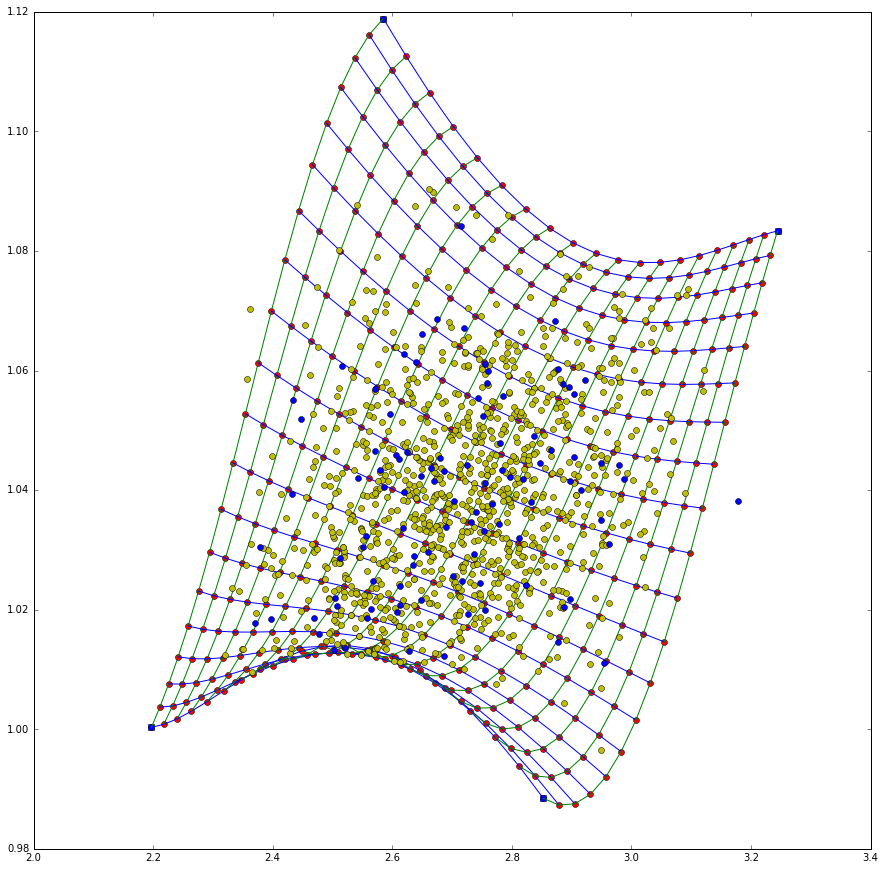

In [60]:
plt.figure(figsize=(15, 15))
plt.plot(x_viz_net[:,0], x_viz_net[:, 1], 'ro')
plt.plot(x_viz_net[0,0], x_viz_net[0, 1], 'bs', label='[-1, -1]')
plt.plot(x_viz_net[380,0], x_viz_net[380, 1], 'bs', label='[-1, 1]')
plt.plot(x_viz_net[19,0], x_viz_net[19, 1], 'bs', label='[1, -1]')
plt.plot(x_viz_net[399,0], x_viz_net[399, 1], 'bs', label='[1, 1]')

for val in np.linspace(-1, 1, 20):
    indices_x = np.where(x_vizualization[:, 0] == val)[0]
    indices_y = np.where(x_vizualization[:, 1] == val)[0]
    for i in range(len(indices_x) - 1):
        plt.plot(x_viz_net[[indices_x[i], indices_x[i+1]], [0, 0]],
                 x_viz_net[[indices_x[i], indices_x[i+1]], [1, 1]],
                 '-b')
    for i in range(len(indices_y) - 1):
        plt.plot(x_viz_net[[indices_y[i], indices_y[i+1]], [0, 0]],
                 x_viz_net[[indices_y[i], indices_y[i+1]], [1, 1]],
                 '-g')

plt.plot(x_tr_net[:,0], x_tr_net[:, 1], 'yo')
plt.plot(x_te_net[:,0], x_te_net[:, 1], 'bo')

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_tr_net = scaler.fit_transform(x_tr_net) / 3
x_te_net = scaler.fit_transform(x_te_net) / 3
x_viz_net = scaler.fit_transform(x_viz_net) / 3

In [65]:
y_tr, y_test = gp.generate_data(x_tr_net.T, x_te_net.T, seed=seed)
y_tr_2, y_viz = gp.generate_data(x_tr_net.T, x_viz_net.T, seed=seed)

In [67]:
np.save('x_tr.npy', x_tr)
np.save('x_te.npy', x_test)
np.save('y_tr.npy', y_tr)
np.save('y_te.npy', y_test)

In [68]:
np.save('P1', P1)
np.save('P2', P2)
np.save('P3', P3)
np.save('b1', b1)
np.save('b2', b2)

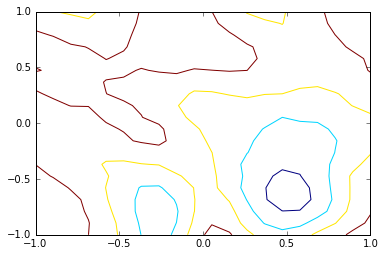

In [66]:
plt.contour(x_grid, y_grid, y_viz.reshape(20, 20), 5)

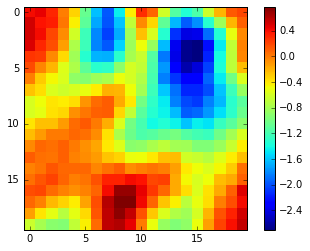

In [64]:
plt.imshow(y_viz.reshape(20, 20), interpolation='Nearest')
plt.colorbar()

Let's checkout the trained model

In [69]:
W1 = np.load('W1.npy')
W2 = np.load('W2.npy')
W3 = np.load('W3.npy')
b1 = np.load('b1.npy')
b2 = np.load('b2.npy')

In [70]:
layer_1 = sigmoid(x_tr.dot(W1) + b1)
layer_2 = sigmoid(layer_1.dot(W2) + b2)
layer_3 = layer_2.dot(W3)
x_tr_trained_net = layer_3

layer_1 = sigmoid(x_test.dot(W1) + b1)
layer_2 = sigmoid(layer_1.dot(W2) + b2)
layer_3 = layer_2.dot(W3)
x_te_trained_net = layer_3

layer_1 = sigmoid(x_vizualization.dot(W1) + b1)
layer_2 = sigmoid(layer_1.dot(W2) + b2)
layer_3 = layer_2.dot(W3)
x_viz_trained_net = layer_3

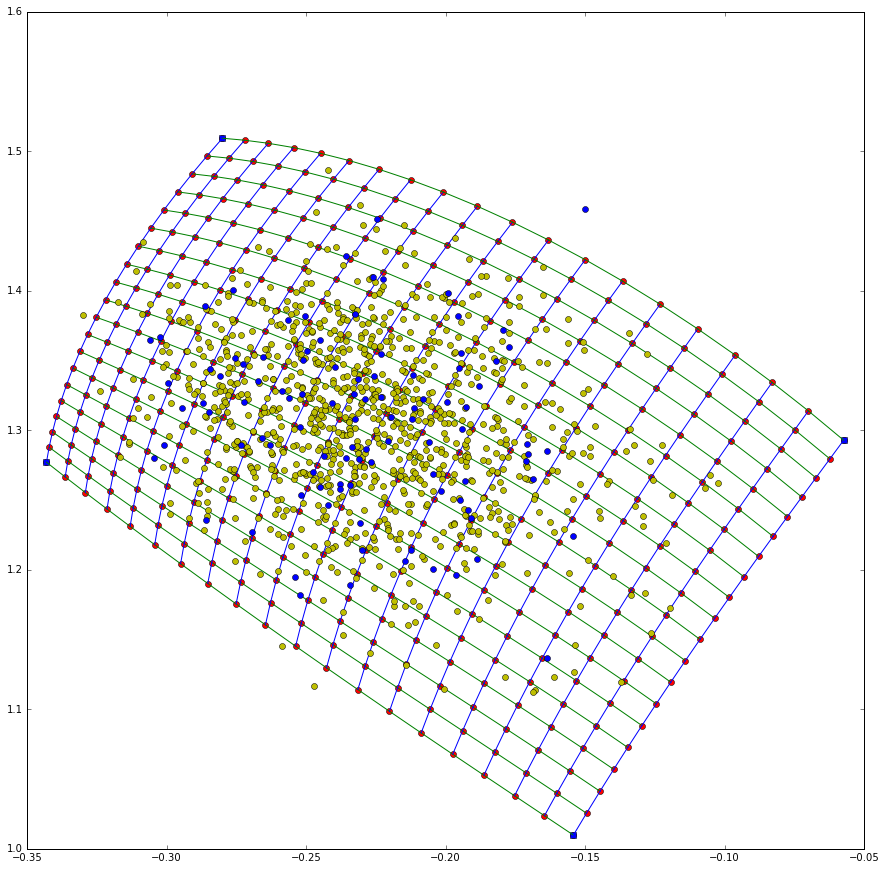

In [71]:
plt.figure(figsize=(15, 15))
plt.plot(x_viz_trained_net[:,0], x_viz_trained_net[:, 1], 'ro')
plt.plot(x_viz_trained_net[0,0], x_viz_trained_net[0, 1], 'bs', label='[-1, -1]')
plt.plot(x_viz_trained_net[380,0], x_viz_trained_net[380, 1], 'bs', label='[-1, 1]')
plt.plot(x_viz_trained_net[19,0], x_viz_trained_net[19, 1], 'bs', label='[1, -1]')
plt.plot(x_viz_trained_net[399,0], x_viz_trained_net[399, 1], 'bs', label='[1, 1]')

for val in np.linspace(-1, 1, 20):
    indices_x = np.where(x_vizualization[:, 0] == val)[0]
    indices_y = np.where(x_vizualization[:, 1] == val)[0]
    for i in range(len(indices_x) - 1):
        plt.plot(x_viz_trained_net[[indices_x[i], indices_x[i+1]], [0, 0]],
                 x_viz_trained_net[[indices_x[i], indices_x[i+1]], [1, 1]],
                 '-b')
    for i in range(len(indices_y) - 1):
        plt.plot(x_viz_trained_net[[indices_y[i], indices_y[i+1]], [0, 0]],
                 x_viz_trained_net[[indices_y[i], indices_y[i+1]], [1, 1]],
                 '-g')

plt.plot(x_tr_trained_net[:,0], x_tr_trained_net[:, 1], 'yo')
plt.plot(x_te_trained_net[:,0], x_te_trained_net[:, 1], 'bo')